In [1]:
# load libraries
library(dplyr)
library("edgeR")
library(Matrix)
library(gplots)
library(RColorBrewer)
library(irlba)
library(proxy)
library(png)
library(tidyverse)
library(ComplexHeatmap)
library(here)
library(preprocessCore)
library(circlize)
`%ni%` <- Negate(`%in%`)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0.9000     ✔ readr     2.1.4     
✔ ggplot2   3.4.3          ✔ stringr   1.5.0     
✔ lubridate 1.9.2          ✔ tibble    3.2.1     
✔ purrr     1.0.2          ✔ tidyr     1.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() m

In [2]:
get_CPM_values <- function(input, meta, cell_annot_alot){
  
  meta_data <- read.delim(meta) %>% 
        rename(cell_type = !!sym(cell_annot_alot)) 
    
    
  raw_cpm_counts_all_genes <- read_delim(input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)
    
  merged_meta_cpm_information <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    group_by(cell_type, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

  ### Alt CPM Calc
  merged_meta_cpm_information_copied <- merged_meta_cpm_information
  catch <- merged_meta_cpm_information_copied  %>%
    group_by(cell_type) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()

  caught_values <- as_tibble(catch)
  #see <- ungroup(merged_meta_cpm_information_copied)
  merged_meta_cpm_information_copied <- bind_cols(merged_meta_cpm_information_copied, caught_values)  %>% 
    rename(grouped_CPM = value)
    
    
  quantile_normalized_values <- merged_meta_cpm_information_copied %>% 
        group_by(cell_type) %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

    
    
  quantile_normalized <- as_tibble(quantile_normalized_values)  %>% 
        dplyr::rename("quant_norm_cpm" = value)


  quantile_normalized_data <- bind_cols(merged_meta_cpm_information_copied, quantile_normalized) %>% 
        group_by(geneID)
        #dplyr::mutate(Zscore = scale(quant_norm_cpm))



  return(quantile_normalized_data)
}



In [3]:
generate_matrix_for_heatmap <- function(cell_type_by_gene_by_quant_norm, markers) {
    
    
    mat <- cell_type_by_gene_by_quant_norm %>%
        dplyr::filter(cell_type %in% c("mesophyll", "bundle_sheath")) %>% 
        dplyr::filter(geneID %in% markers$geneID) %>% 
        left_join(., markers, by = c("geneID")) %>% 
        dplyr::ungroup() %>%   
        dplyr::select(cell_type, name, quant_norm_cpm) %>% 
        pivot_wider(names_from = cell_type, values_from = quant_norm_cpm) %>% 
        dplyr::rowwise() %>% 
        dplyr::mutate(log2_val = log2(bundle_sheath/mesophyll)) %>% 
        dplyr::select(name, log2_val) 
}

In [4]:
output_location <- "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_2/heatmaps/"

In [6]:
zm_input_data <- "/scratch/jpm73279/comparative_single_cell/04.marker_annotation/zea_mays/acc_metrics_zea_may.v4_annot/zea_mays.gene_body_acc_zea_may.v4_annot.counts.txt"
zm_meta <- "/scratch/jpm73279/comparative_single_cell/07.call.ACRs/replicate_analysis_one_off/zm/Zm.leaf_annot.V5.meta.frozen.txt"
zm_marker_file <-"/home/jpm73279/genome_downloads/C4_markers/Zm.c4_markers.bed"
zm_markers <- read_delim(zm_marker_file, delim = "\t", col_names = c("chrom", "start", "stop", "geneID", "name", "type"))

Rows: 33 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom, geneID, name, type
dbl (2): start, stop

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
zm_cpm_values <- get_CPM_values(zm_input_data, zm_meta, "final_annotation")
zm_C4_matrix <- generate_matrix_for_heatmap(zm_cpm_values, zm_markers)
zm_df <- data.frame(zm_C4_matrix, row.names = 1)

Rows: 22253352 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


In [10]:
# Function definition
filter_tribble_by_name <- function(data, names) {
  updated <- data %>%
    filter(name %in% names)
    
    updated <- data.frame(updated, row.names = 1)
    return(updated)
}


# Generate Core C4 Gene Heatmaps

In [11]:
col_fun <- colorRamp2(c(-2, 0, 2), c("red", "white", "blue"))


generate_split_heatmap <- function(log2matrix, df_marker_type) {
    
     updated <- log2matrix %>%
        filter(name %in% df_marker_type$name) %>% 
        left_join(.,df_marker_type, by = c("name")) %>% 
        dplyr::group_by(cell_type) %>% 
        dplyr::arrange(desc(log2_val)) %>% 
        mutate(name = str_replace_all(name, "_ortho_count_", "_"))


    return(updated)
    
}

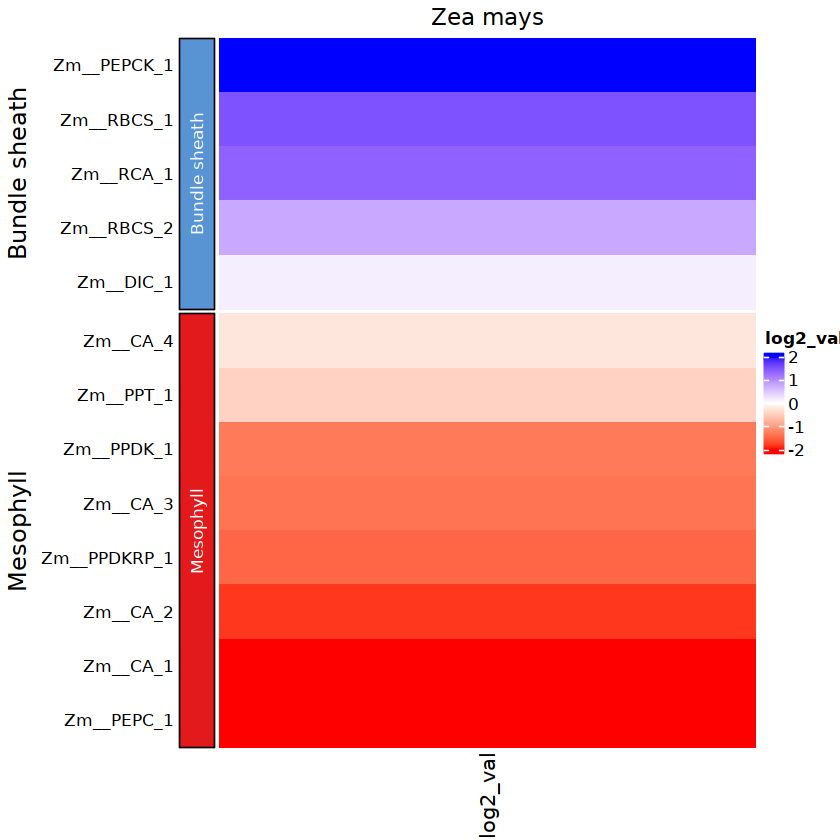

In [13]:
names <- c("Zm__CA_1", "Zm__CA_2", "Zm__CA_4", "Zm__CA_3",
           "Zm__PPDK_1", "Zm__PEPCK_1", "Zm__RBCS_1", "Zm__RBCS_2",
           "Zm__RCA_1", "Zm__PPT_1", "Zm__DIC_1", "Zm__PPDKRP_1", "Zm__PEPC_1")
cell_types <- c("Mesophyll", "Mesophyll", "Mesophyll", "Mesophyll",
                "Mesophyll", "Bundle sheath", "Bundle sheath", "Bundle sheath",
                "Bundle sheath", "Mesophyll", "Bundle sheath", "Mesophyll","Mesophyll")

# Create dataframe
zm_genes <- data.frame(name = names, cell_type = cell_types)


zm_data_merged <- generate_split_heatmap(zm_C4_matrix ,zm_genes)

zm_data_generate_matrix <- as.matrix(zm_data_merged[,"log2_val"])
rownames(zm_data_generate_matrix) <- zm_data_merged$name

# create heatmap
zm_heatmap <- Heatmap(zm_data_generate_matrix, name = "log2_val",
                   col = col_fun,
                   row_names_gp = gpar(fontsize = 10),
                   split = zm_data_merged$cell_type,
                    row_names_side = "left",
                   show_row_names = TRUE,
                   cluster_rows = FALSE,
                   #row_title = "Gene",
                   row_title_side = "left",
                    left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#5894D4", "#E31A1C")),
                        labels = unique(zm_data_merged$cell_type), 
                        labels_gp = gpar(col = "white", fontsize = 10))),  
                     column_title = "Zea mays",
                   row_title_gp = gpar(fontsize = 14))

zm_heatmap

# Generate heatmap for Subtypes

In [ ]:
zm_genes_subtypes

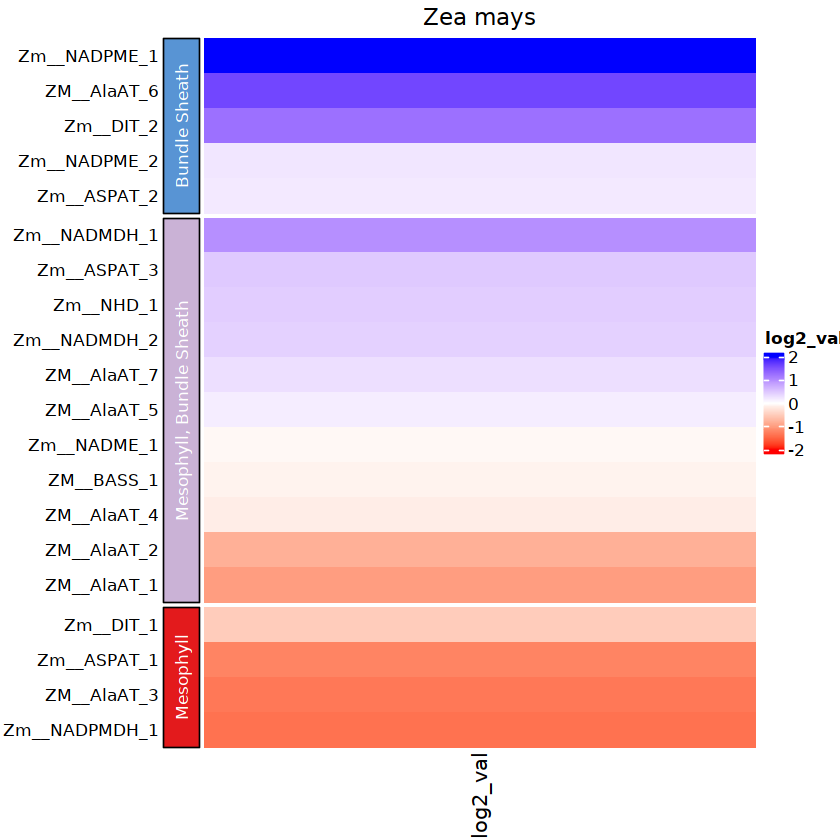

In [15]:

#zm_genes_subtypes <- data.frame(
#  name = c("NADP_ME1", "NAD_ME10", "NAD_ME12", "NAD_ME1", "ASP_AT1", "NADP_MDH"),
#  cell_type = c("Bundle Sheath", "Mesophyll,Bundle Sheath", "Mesophyll,Bundle Sheath", "Mesophyll,Bundle Sheath", "Mesophyll", "Mesophyll")
#)
zm_genes_subtypes  <- data.frame(
  name = c("ZM__AlaAT_1", "ZM__AlaAT_4", "ZM__AlaAT_3", "ZM__AlaAT_2", "ZM__AlaAT_5",
           "Zm__ASPAT_1", "Zm__ASPAT_2", "ZM__BASS_1", "Zm__DIT_1", "Zm__DIT_2",
           "Zm__NADMDH_1", "Zm__NADPMDH_1", "Zm__NADPME_1", "Zm__NADPME_2", 
           "Zm__NHD_1", "ZM__AlaAT_6", "Zm__NADME_1", "ZM__AlaAT_7", "Zm__NADMDH_2",
           "Zm__ASPAT_3"),
  cell_type = c("Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll", 
                "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll", 
                "Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll", 
                "Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll", "Bundle Sheath", 
                "Bundle Sheath", "Mesophyll, Bundle Sheath", "Bundle Sheath", 
                "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath",
                "Mesophyll, Bundle Sheath")
)


zm_genes_subtypes$cell_type <- as.factor(zm_genes_subtypes$cell_type)
zm_genes_subtypes$cell_type <- factor(zm_genes_subtypes$cell_type, levels = c("Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll"))    
zm_genes_subtypes <- zm_genes_subtypes %>% 
    arrange(cell_type)




zm_data_merged_subtypes <- generate_split_heatmap(zm_C4_matrix, zm_genes_subtypes)
zm_data_generate_matrix_subtypes <- as.matrix(zm_data_merged_subtypes[,"log2_val"])
rownames(zm_data_generate_matrix_subtypes) <- zm_data_merged_subtypes$name

# create heatmap
zm_heatmap_nadpme <- Heatmap(zm_data_generate_matrix_subtypes, name = "log2_val",
                   col = col_fun,
                   row_names_gp = gpar(fontsize = 10),
                   split = zm_data_merged_subtypes$cell_type,
                    row_names_side = "left",
                   show_row_names = TRUE,
                   cluster_rows = FALSE,
                   row_title = NULL,
                   row_title_side = "left",
                    left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#5894D4","#CAB2D6","#E31A1C")),
                        labels = unique(zm_data_merged_subtypes$cell_type), 
                        labels_gp = gpar(col = "white", fontsize = 10))),  
                     column_title = "Zea mays",
                   row_title_gp = gpar(fontsize = 14))

zm_heatmap_nadpme

In [16]:
output_function <- function(output_place, heatmap, name) {
    file_name <- paste0(output_place, name)
    pdf(file = file_name, height = 6, width = 4)
    draw(heatmap)
    dev.off()
}

In [17]:
output_function(output_location, zm_heatmap, "zm_core_c4_genes.pdf")
output_function(output_location, zm_heatmap_nadpme, "zm_variable_c4_genes.pdf")

png 
  2

png 
  2